In [1]:
from ortools.sat.python import cp_model

load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\ziya\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...


In [2]:
freq = []
volume = []

for i in range(3):
    freq.append(int(input(f"Enter frequency for prodct {i}: ")))
    volume.append(int(input(f"Enter volume for product {i}: ")))

products = {
    'p1': {'volume': volume[0], 'freq': freq[0]},
    'p2': {'volume': volume[1], 'freq': freq[1]},
    'p3': {'volume': volume[2], 'freq': freq[2]}
}

slots_dist = []
for i in range(3):
    slots_dist.append(int(input(f"Enter distance for slot {i}: ")))


sorted_products = sorted(products.items(), key=lambda x:x[1]['freq'], reverse=True)
products_name = [p[0] for p in sorted_products]

In [3]:
model = cp_model.CpModel()
#setting vars
products_vars = {}
for pname in products:
    products_vars[pname] = model.new_int_var(0, 2, pname) 
    """
    {
        'p1': <INT_VAR in P1 [0, 1, 2]>, 
        'p2': <INT_VAR in P2 [0, 1, 2]>,
        'p3': <INT_VAR in P3 [0, 1, 2]>
    }
    """
    #p1, p2 and p3 will be assigned any of these slots(later in prog based on constarints)

In [4]:
#constraint 1: each product must be assigned to different slot = if space is 0, then slot 0 is assigned to p1, if space is 1, then slot 1 is assigned to p2 and so on
model.add_all_different(products_vars.values())

#constraint 2: each slot must be assigned to the slot based on freq
for i in range(len(products_name)-1):
    P1 = products_name[i]
    P2 = products_name[i+1]
    model.add(products_vars[P1] <= products_vars[P2]) #assigns BUT AT RUN TIME(so we dont knowits value rn) p1(higher freq product) a slot which is less than or equal to the slot assigned to p2(lower freq product)

#minimizing walking distance for workers
cost_terms = []
for pname in products:
    p_var = products_vars[pname]
    #intermediate var for distance
    distance = model.new_int_var(min(slots_dist), max(slots_dist), f'distance_{pname}')
    cost = model.new_int_var(0, max(slots_dist)*products[pname]['freq'], f'cost_{pname}')
    #distance = slots_dist[slot assigned to p1]

    model.add_element(p_var, slots_dist, distance) #distance = slots_dist[slot assigned to p1]  

    model.add_multiplication_equality(cost, [distance, products[pname]['freq']]) #cost = distance * freq of product
    cost_terms.append(cost) #cost_terms = [cost of p1, cost of p2, cost of p3]

model.minimize(sum(cost_terms)) #minimizing the sum of all costs (get the smallest cost possible)

In [5]:
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Assignment with Frequency-Proximity Constraint:")
    for p in products:
        assigned_slot = solver.Value(products_vars[p])
        print(f"{p} → Slot {assigned_slot + 1} (Distance = {slots_dist[assigned_slot]})")
    print(f"Total Weighted Walking Distance: {solver.ObjectiveValue()}")
else:
    print("No feasible solution found.")

Assignment with Frequency-Proximity Constraint:
p1 → Slot 2 (Distance = 2)
p2 → Slot 3 (Distance = 3)
p3 → Slot 1 (Distance = 1)
Total Weighted Walking Distance: 59.0


C:\Users\ziya\AppData\Local\Temp\ipykernel_11300\466235463.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  dispatch_rect = plt.Rectangle((-1, 0), 1, 1, fill=True, color="#ffdddd", edgecolor='black')
C:\Users\ziya\AppData\Local\Temp\ipykernel_11300\466235463.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x, 0), 1, 1, fill=True, color="#cfe2f3", edgecolor='black')


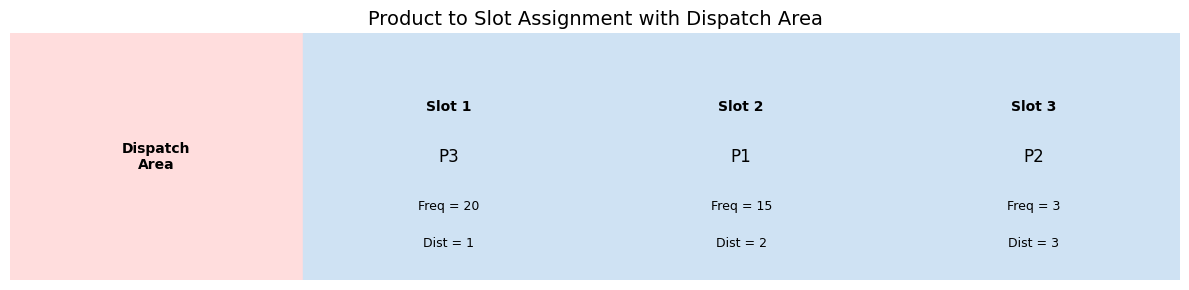

In [6]:
import matplotlib.pyplot as plt

def draw_slot_map(products, slots, product_assignment):
    # Create reverse map for slot → product
    slot_to_product = {v: k for k, v in product_assignment.items()}

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(-1, len(slots))
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Draw Dispatch Area
    dispatch_rect = plt.Rectangle((-1, 0), 1, 1, fill=True, color="#ffdddd", edgecolor='black')
    ax.add_patch(dispatch_rect)
    ax.text(-0.5, 0.5, "Dispatch\nArea", ha='center', va='center', fontsize=10, weight='bold')

    # Draw Slots
    for slot in range(len(slots)):
        x = slot
        rect = plt.Rectangle((x, 0), 1, 1, fill=True, color="#cfe2f3", edgecolor='black')
        ax.add_patch(rect)

        product = slot_to_product.get(slot, "Empty")
        freq = products[product]['freq'] if product in products else '-'
        dist = slots[slot]

        ax.text(x + 0.5, 0.7, f"Slot {slot+1}", ha='center', va='center', fontsize=10, weight='bold')
        ax.text(x + 0.5, 0.5, f"{product.upper()}", ha='center', va='center', fontsize=12)
        ax.text(x + 0.5, 0.3, f"Freq = {freq}", ha='center', va='center', fontsize=9)
        ax.text(x + 0.5, 0.15, f"Dist = {dist}", ha='center', va='center', fontsize=9)

    plt.title("Product to Slot Assignment with Dispatch Area", fontsize=14)
    plt.tight_layout()
    plt.show()


# === DYNAMIC INPUT (simulate what main code does) ===
# Read from user
freq = []
volume = []
for i in range(3):
    freq.append(int(input(f"Enter frequency for product {i+1}: ")))
    volume.append(int(input(f"Enter volume for product {i+1}: ")))

products = {
    'p1': {'volume': volume[0], 'freq': freq[0]},
    'p2': {'volume': volume[1], 'freq': freq[1]},
    'p3': {'volume': volume[2], 'freq': freq[2]}
}

slots_dist = []
for i in range(3):
    slots_dist.append(int(input(f"Enter distance for slot {i+1}: ")))

slots = {
    0: slots_dist[0],
    1: slots_dist[1],
    2: slots_dist[2]
}


product_assignment = {
    'p1': 1,
    'p2': 2,
    'p3': 0 
}
for pname in products:
    slot = int(input(f"Enter assigned slot (0,1,2) for {pname}: "))
    product_assignment[pname] = slot

# === DRAW ===
draw_slot_map(products, slots, product_assignment)
